# Expected Epidemic Size of Mask Model

## 1. Condition on num of neighbors from lower level

$A_L$ := Node v becomes **active** at level L

$B_k$ := Node v has $k - 1$ lower level neighbors

$P(A_L) = \sum_{k = 1}^{\infty}{P(A_L | B_k) * P(B_k)}$

where

$P(B_k) = \frac{k p_{k}}{\langle k\rangle}$


## 2. Condition on num of lower level neighbors who wear masks

$C_m$ := $m$ of $k-1$ lower level neighbors wear masks

$P(A_L | B_k) = \sum_{m = 0}^{k-1}P(A_L | B_k, C_m) * P(C_m) $

where

$P(C_m) = \left(\begin{array}{c}
k-1 \\
m
\end{array}\right) * P_{mask}^m * (1 - {P_{mask}})^{(k-1-m)} $



## 3. Condition on the num of infected lower level neighbors *


$X$ and $Y$ represent num of infection received from people who wearing masks and not wearing masks


$X \sim \operatorname{Binomial}\left(m, A_{L-1}\right)$

$Y \sim \operatorname{Binomial}\left(k - 1 -m, A_{L-1}\right)$



$E_{x,y}$ := $x$ num of infection received from neighbors who wear masks, $y$ num of infection received from neighbors who don't wear masks


$P(A_L | B_k, C_m) = \sum_{x = 0}^{m}\sum_{y = 0}^{k-1-m}\left(\begin{array}{c}
m \\
x
\end{array}\right)  \left(\begin{array}{c}
k - 1 - m \\
y
\end{array}\right) * A_{L-1}^{x + y} * (1 -  A_{L-1})^{(k -1 - x -y)} * P(A_L | B_k, C_m, E_{x,y})$


## 4. Condition on whether node v itself wears a mask *

$D$ := Node v wears a mask

$ \overline D$ := Node v doesn't wear a mask

$P(D) = P_{mask}$

$P(A_L | B_k, C_m, E_{x,y}) = P(A_L | B_k, C_m, E_{x,y}, D) * P(D) + P(A_L | B_k, C_m, E_{x,y}, \overline D) * P(\overline D) $

## 5. $P(A_L | B_k, C_m, E_{x,y}, D)$
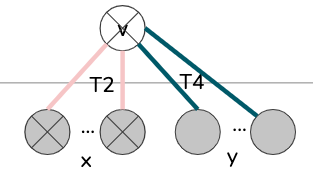

$R := A_L | B_k, C_m, E_{x,y}, D$

**How node V get infected:**
As long as one of his infectious neighbor infect him successfully.

* No mutation.
* **Only one strain here**
    The transmissibility only depends on the edge type.



$P(\overline R) = (1 - T_2)^x * (1 - T_4)^y$

$P(R) = 1 - P(\overline R) = 1 - (1 - T_2)^x * (1 - T_4)^y$

## 6. $P(A_L | B_k, C_m, E_{x,y}, \overline D)$

$S$ := $A_L | B_k, C_m, E_{x,y}, \overline D$

$P(S) = 1 - (1 - T_1)^x * (1 - T_3)^y$
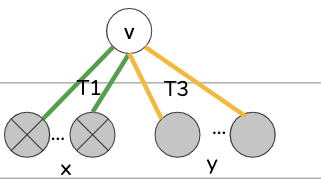

# Iterative function

$A_L = f(A_{L-1}, meanDegree, P_{mask})$

Epidemic size: fixed point of the equation.

# Question
1. Prob of emergence
Prob of emergence = 1 - Prob of extinction.

Prob of ext: q = f(q)

2. Epidemic Size
$ q_{L + 1} = f(q_L), L \rightarrow \infty$

3. $q_0$ should be started from 0?

4. Think about how to generate the k-pk pairs

In [47]:
from operator import mul    # or mul=lambda x,y:x*y
from fractions import Fraction
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt

In [31]:
def nCk(n,k): 
    return int(round(reduce(mul, (float(n-i)/(i+1) for i in range(k)), 1)))

In [32]:
def P_S(x, y, T1, T3):
    res = 1 - ((1 - T1) ** x) * ((1 - T3) ** y)
    assert res >= 0, "P_S should be greater than 0"
    assert res < 1, "P_S should be less than 1"
    return res

In [33]:
def P_R(x, y, T2, T4):
    res = 1 - ((1 - T2) ** x) * ((1 - T4) ** y)
    assert res >= 0, "P_S should be greater than 0"
    assert res < 1, "P_S should be less than 1"
    return res

In [34]:
def P_ABCE(P_mask, T_list, x, y):
    p_r = P_R(x, y, T_list[1], T_list[3])
    p_s = P_S(x, y, T_list[0], T_list[2])
    res = p_r * P_mask + p_s * (1 - P_mask)
    assert res >= 0, "P_R should be greater than 0"
    assert res < 1, "P_R should be less than 1"
    return res

In [35]:
def P_ABC(P_mask, T_list, m, k, A_lower):
    y_range = k - 1 - m
    p_abc = 0
    one_minus_A_lower = 1 - A_lower
    for x in range(m + 1):
        for y in range(y_range + 1):
            p_abce = P_ABCE(P_mask, T_list, x, y)
            p_abc += nCk(m, x) * nCk(y_range, y) * p_abce * \
                     (A_lower ** (x + y)) * \
                     (one_minus_A_lower ** (k - 1 - x - y))
    
    assert p_abc >= 0, "P_ABC should be greater than 0"
    assert p_abc < 1, "P_ABC should be less than 1"
    return p_abc

In [36]:
def P_AB(P_mask, T_list, k, A_lower):
    one_minus_pmask = 1 - P_mask
    p_ab = 0
    for m in range(k):
        p_c = nCk(k-1, m) * (P_mask ** m) * (one_minus_pmask ** (k - 1 - m))
        p_abc = P_ABC(P_mask, T_list, m, k, A_lower)
        p_ab += p_abc * p_c
    assert p_ab >= 0, "P_AB should be greater than 0"
    assert p_ab < 1, "P_AB should be less than 1"
    return p_ab

In [37]:
def generate_degree_list(mean_degree, nodeN):
    sequence = np.random.poisson(mean_degree, nodeN)
    while (np.sum(sequence) % 2 !=0):
        sequence = np.random.poisson(mean_degree, nodeN)
    
    p_k = dict() # degree prob dict
    
    len_seq = len(sequence)
    for i in sequence:
        if i in p_k.keys():
            p_k[i] += 1/len_seq
        else:
            p_k[i] = 1/len_seq
    
    k_max = max(p_k.keys()) # largest degree in the graph
    
    return p_k, k_max

In [38]:
def P_A(mean_degree, nodeN, P_mask, T_list, A_lower):
    P_k_dict, k_max = generate_degree_list(mean_degree, nodeN)
    pa_L = 0
    for k in range(1, k_max):
        if k not in P_k_dict.keys():
            p_k = 0
        else:
            p_k = P_k_dict[k]
        p_b = k * p_k / mean_degree
        p_ab = P_AB(P_mask, T_list, k, A_lower)
        pa_L += p_ab * p_b
        
        assert p_ab >= 0, "P_AB should be greater than 0"
        assert p_ab < 1, "P_AB should be less than 1"
    return pa_L

In [68]:
def get_ProbEmergence(mean_degree, nodeN, P_mask, T_list, A_lower):
    ### Solve f(q) = q to get Prob of EXT. ###
    p_a_L = P_A(mean_degree, nodeN, P_mask, T_list, A_lower)

    while abs(A_lower - p_a_L) > thr:
        A_lower = p_a_L
        p_a_L = P_A(mean_degree, nodeN, P_mask, T_list, p_a_L)
    return p_a_L

In [69]:
def get_EpidemicSize(mean_degree, nodeN, P_mask, T_list, A_lower):
    ### Get PA when level -> +inf ###
    inf = nodeN # max level of a tree i
    p_a_L = A_lower
    for i in range(inf):
        p_a_L = P_A(mean_degree, nodeN, P_mask, T_list, p_a_L)
    return p_a_L

In [91]:
# Parameters setup

init_A_lower = 0.00001
thr = 0.00000001
mean_degree = 5
nodeN = 50000
P_mask = 0.6
T_list = [0.00480, 0.03200, 0.32000, 0.04800]
mean_degree_list = np.linspace(0, 10, 50)

Text(0.5, 1.0, 'Theoratical Prob of Emergence for Mask Model')

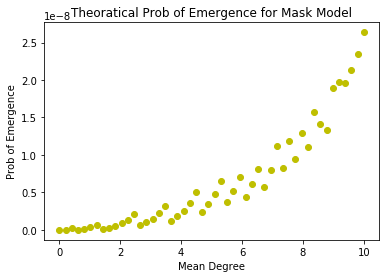

In [92]:
prob_emergence_list = []

for mean_degree in mean_degree_list:
    prob_emergence_list.append(get_ProbEmergence(mean_degree, nodeN, P_mask, T_list, init_A_lower))
    
plt.figure()
plt.plot(mean_degree_list, prob_emergence_list, 'yo')
plt.xlabel("Mean Degree")
plt.ylabel("Prob of Emergence")
title = "Theoratical Prob of Emergence for Mask Model"
plt.title(title)

In [ ]:
infection_size = []

for mean_degree in mean_degree_list:
    infection_size.append(get_EpidemicSize(mean_degree, nodeN, P_mask, T_list, init_A_lower))

plt.figure()
plt.plot(mean_degree_list, infection_size, 'yo')
plt.xlabel("Mean Degree")
plt.ylabel("Infection Fraction")
title = "Theoratical Infection Fraction for Mask Model"
plt.title(title)